In [1]:
import numpy as np
import zephyr.backend
import zephyr.middleware
import SimPEG

In [2]:
nx = 100
nz = 200
cBackground = 2500.
cAnomaly = -500.

cInitial = cBackground * np.ones((nz,nx))

cUpdate = np.zeros((nz,nx))
cUpdate[(nz/2)-10:(nz/2)+10,(nx/2)-10:(nx/2)+10] = cAnomaly

cTrue = cInitial + cUpdate

sz = np.arange(25, nz-24, 1)
sx = 25. * np.ones((len(sz),))
rz = np.arange(25, nz-24, 1)
rx = (nx - 25.) * np.ones((len(rz),))

geom = {
    'src':      np.vstack([sx, sz]).T,
    'rec':      np.vstack([rx, rz]).T,
}

systemConfig = {
    'dx':       1.,                             # m
    'dz':       1.,                             # m
    'c':        cTrue.ravel(),                  # m/s
    'rho':      1.,                             # kg/m^3
    'nx':       nx,                             # count
    'nz':       nz,                             # count
    'freqs':    np.arange(50, 450, 50),         # Hz
    'Disc':     zephyr.backend.MiniZephyrHD,    # discretization
    'geom':     geom,                           # dictionary
    'nWorkers': 4,
}

In [3]:
problem = zephyr.middleware.Helm2DViscoProblem(systemConfig)
survey  = zephyr.middleware.Helm2DSurvey(systemConfig)
problem.pair(survey)

In [4]:
%%time
dObs = survey.dpred()

CPU times: user 848 ms, sys: 604 ms, total: 1.45 s
Wall time: 8.46 s


In [5]:
survey.dobs = dObs
survey.std = 1.

dmisfit = SimPEG.DataMisfit.l2_DataMisfit(survey)
dmisfit.Wd = 1.

opt = SimPEG.Optimization.ProjectedGradient()
reg = zephyr.middleware.HelmBaseRegularization(problem.mesh)

invProb = SimPEG.InvProblem.BaseInvProblem(dmisfit, reg, opt)
inv = SimPEG.Inversion.BaseInversion(invProb)

In [6]:
# mOpt = inv.run(cInitial.ravel())

In [7]:
import scipy.optimize

In [8]:
# misfit = lambda x: invProb.evalFunction(x, True, False)
# res = scipy.optimize.minimize(misfit, cInitial.ravel(), jac=True, method='Newton-CG')
res = scipy.optimize.minimize(dmisfit.eval, cInitial.ravel(), jac=dmisfit.evalDeriv, method='Newton-CG')

/Users/brendan/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/Users/brendan/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:436: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/Users/brendan/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:437: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/Users/brendan/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:438: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 0] = -dc ** 3
/Users/brendan/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:439: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3


Populating the interactive namespace from numpy and matplotlib


<matplotlib.colorbar.Colorbar instance at 0x109a6d248>

/Users/brendan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


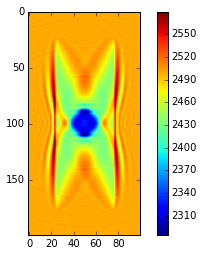

In [12]:
%pylab inline

imshow(res.x.reshape((nz,nx)))
colorbar()

In [ ]:
# REALLY BADLY SCALED; MAKE A MAPPING TO SQUARED SLOWNESS